In [38]:
import pymongo

def create_connection():
    try:
        client = pymongo.MongoClient("mongodb://localhost:27017/")
        return client["IUM"], client
    except pymongo.errors.ConnectionFailure as e:
        print(f"Connection failed: {e}")
        return None, None


def close_connection(client):
    # Close connection
    if client is not None:  # Check for None explicitly
        client.close()
 

The stats will be about a subject chosen between:
 - "players"
 - "clubs"
 - "competitions"

In [39]:
subject = "players"

The user defines the stats that wants to see. Stats is a tuple of 3 integer elements, always in the next order:
(Goals, Assists, Cards)
Here are some examples of how the tuple could be in different cases:
If the user wants to see the only goals and assists, the value of the tuple will be (1,1,0).
If the user wants to see the only goals and cards, the value of the tuple will be (1,0,1).
If the user wants to see the only goals, the value of the tuple will be (1,0,0).
If the user wants to see those three assists, the value of the tuple will be (1,1,1).

In [40]:
stats = (1,0,1)

Choose the information of the subject to search for stats, the options are:
 - "name"
 - "country"

In [41]:
subject_info = "name"

Once chosen, indicate here the name of the subject in case of "name", or the country in case of "country".

Last, it will be chosen the period of years in which the user want to get stats. If the user only wants the stats of one year, "initial_year" and "final_year" will have the same value. The range of years goes from 2012 to 2023.

In [42]:
initial_year = 2012
final_year = 2020

In [43]:
db, client = create_connection()

In [44]:
subject_info_key = "Theo Janssen"

In [45]:
def getPlayerId(db, name):
    try:
        # query_european_holidays = {"visa": {"$exists": False}}
        #european_holidays = list(collection.find(query_european_holidays))
        
        collection = db["players"]
        query = {"name": name}
        playerId = list(collection.find(query))
        return playerId[0].get("player_id")
    except Exception as e:
            print(f"Retrieval of Clubs failed: {e}")
            return []

In [46]:
print(getPlayerId(db, subject_info_key))

4425


In [47]:
def player_stats(db, subject, stats, subject_info, subject_info_key, initial_year, final_year):
    if subject == "players":
        try:
            main_collection = db["players"]
            collection_events = db["game_events"]
            player_id = getPlayerId(db,subject_info_key)
            print(player_id)
            pipeline = [
                        {
                           "$lookup": {
                                 "from": "game_events", 
                                 "localField": "player_id", 
                                 "foreignField": "player_id", 
                                 "as": "player_events",
                            }
                        },
                        {
                            "$match": {
                                "player_id": player_id
                            }
                        },
                        {
                            "$unwind": "$player_events"
                        },
                        {
                            "$group": {
                                "_id": "$player_id",
                                "total_goals": {
                                    "$sum": {
                                        "$cond": [
                                            {"$eq": ["$player_events.type", "Goals"]},
                                            1,
                                            0
                                        ]
                                    }
                                },
                                "total_cards": {
                                    "$sum": {
                                        "$cond": [
                                            {"$eq": ["$player_events.type", "Cards"]},
                                            1,
                                            0
                                        ]
                                    }
                                }
                            }
                        },
                        {
                            "$project": {
                                "_id": 0,
                                "player_id": "$_id",
                                "total_goals": 1,
                                "total_cards": 1
                            }
                        }
                        
            ]
            resultado_agregacion = list(main_collection.aggregate(pipeline))
            return resultado_agregacion
        except Exception as e:
            print(f"Retrieval of Clubs failed: {e}")
            return []
    else:
        return []


In [48]:
result = player_stats(db,"players",(1,0,0),"country_of_citizenship", subject_info_key, 2012,2012)
for x in result:
    print(x)

4425
{'total_goals': 6, 'total_cards': 8, 'player_id': 4425}


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

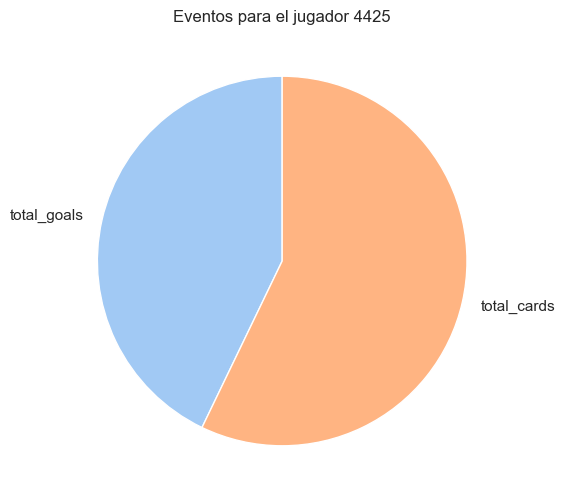

In [50]:
# Extraer el diccionario de la lista
data = result[0]
player_id = data.get("player_id")
data.pop('player_id', None)

# Crear un DataFrame
df = pd.DataFrame(list(data.items()), columns=['Event', 'Count'])

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de pie
plt.figure(figsize=(8, 6))
plt.pie(df['Count'], labels=df['Event'], startangle=90, colors=sns.color_palette('pastel'))
plt.title(f"Eventos para el jugador {player_id}")
plt.show()
